## Setup

In [2]:
# Environment setup
import sys
from pathlib import Path

# Add src to path
workspace_root = Path.cwd()
while not (workspace_root / 'src').exists() and workspace_root != workspace_root.parent:
    workspace_root = workspace_root.parent

sys.path.insert(0, str(workspace_root / 'src'))

print(f"Project root: {workspace_root}")
print(f"Python version: {sys.version}")
print("✓ Environment configured")

Project root: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Python version: 3.12.0 (v3.12.0:0fb18b02c8, Oct  2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]
✓ Environment configured


In [3]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Embeddings (same as Reddit 15b)
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Thesis pipeline utilities
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All imports successful")

✓ All imports successful


## 1. Load News Articles

In [5]:
# Paths
silver_dir = workspace_root / 'data' / '01_corpus' / '01_silver' / 'news'
topics_dir = workspace_root / 'data' / '02_topics' / 'news'
reddit_topics_dir = workspace_root / 'data' / '02_topics' / 'reddit'
topics_dir.mkdir(parents=True, exist_ok=True)

print(f"Silver data: {silver_dir}")
print(f"Topics output: {topics_dir}")
print(f"Reddit topics (source): {reddit_topics_dir}")

# Check for silver data
silver_files = sorted(silver_dir.glob('2016-*.parquet'))
if not silver_files:
    raise FileNotFoundError(
        f"No silver layer files found in {silver_dir}\\n"
        "Please run notebook 21 first to create silver layer data."
    )

# Check for Reddit topic definitions (we'll reuse them)
if not (reddit_topics_dir / 'topic_definitions.json').exists():
    raise FileNotFoundError(
        f"Reddit topic definitions not found: {reddit_topics_dir / 'topic_definitions.json'}\\n"
        "Please run Reddit notebook 15a first to create topic definitions."
    )

print(f"\n✓ Found {len(silver_files)} daily parquet files")
print(f"✓ Found Reddit topic definitions")

Silver data: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/01_corpus/01_silver/news
Topics output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/news
Reddit topics (source): /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit

✓ Found 61 daily parquet files
✓ Found Reddit topic definitions


In [6]:
# Load all news articles
print("Loading all news articles...")
all_articles = []

for file in tqdm(silver_files, desc="Reading files"):
    df = read_parquet(file)
    all_articles.append(df)

df = pd.concat(all_articles, ignore_index=True)

print(f"\n✓ Loaded {len(df):,} news articles")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"\nColumns: {df.columns.tolist()}")

Loading all news articles...


Reading files:   0%|          | 0/61 [00:00<?, ?it/s]


✓ Loaded 93,669 news articles

Date range: 2016-09-01 to 2016-10-31

Columns: ['date', 'requested_url', 'plain_text', 'published_date', 'title', 'tags', 'categories', 'author', 'sitename', 'image_url', 'language', 'language_score', 'responded_url', 'publisher', 'warc_path', 'crawl_date']


In [7]:
# Data overview
print("Data overview:")
print(f"\nTotal articles: {len(df):,}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nText fields available:")
print(f"  - title: {df['title'].notna().sum():,} ({df['title'].notna().sum()/len(df)*100:.1f}%)")
print(f"  - plain_text: {df['plain_text'].notna().sum():,} ({df['plain_text'].notna().sum()/len(df)*100:.1f}%)")

print(f"\nText length statistics:")
print(f"  Title: {df['title'].str.len().mean():.0f} chars (mean)")
print(f"  Article: {df['plain_text'].str.len().mean():.0f} chars (mean)")

Data overview:

Total articles: 93,669
Date range: 2016-09-01 to 2016-10-31

Text fields available:
  - title: 93,669 (100.0%)
  - plain_text: 93,669 (100.0%)

Text length statistics:
  Title: 58 chars (mean)
  Article: 2699 chars (mean)


## 2. Load Topic Definitions and Embeddings

Load the same topic definitions and embeddings from Reddit (notebook 15a).

In [8]:
# Load topic definitions from Reddit
with open(reddit_topics_dir / 'topic_definitions.json', 'r') as f:
    topic_definitions = json.load(f)

print("Loaded topic definitions:")
for topic_id, topic_info in topic_definitions.items():
    print(f"  {topic_id}: {topic_info['label']}")

# Load topic embeddings from Reddit
embeddings_matrix = np.load(reddit_topics_dir / 'topic_embeddings.npy')
with open(reddit_topics_dir / 'topic_ids.json', 'r') as f:
    topic_ids = json.load(f)

# Create dictionary mapping topic_id -> embedding
topic_embeddings = {topic_id: embeddings_matrix[i] for i, topic_id in enumerate(topic_ids)}

print(f"\n✓ Loaded {len(topic_embeddings)} topic embeddings")
print(f"  Embedding dimension: {embeddings_matrix.shape[1]}")

Loaded topic definitions:
  climate_change: Climate Change
  donald_trump: Donald Trump
  gun_control: Gun Control
  immigration: Immigration
  vaccination: Vaccination

✓ Loaded 5 topic embeddings
  Embedding dimension: 384


## 3. Load Sentence Embedding Model

Load the same model used for Reddit (sentence-transformers).

In [9]:
# Load sentence embedding model (same as Reddit 15b)
print("Loading sentence embedding model...")
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

print(f"✓ Loaded model: {model_name}")
print(f"  Embedding dimension: {model.get_sentence_embedding_dimension()}")
print(f"  Max sequence length: {model.max_seq_length}")

Loading sentence embedding model...
✓ Loaded model: sentence-transformers/all-MiniLM-L6-v2
  Embedding dimension: 384
  Max sequence length: 256


## 4. Prepare Article Texts and Embed

In [10]:
# Prepare article texts (title + text, same as Reddit)
print("Preparing article texts...")

# Combine title and text for embedding
article_texts = (
    df['title'].fillna('') + ' ' + 
    df['plain_text'].fillna('')
).tolist()

print(f"✓ Prepared {len(article_texts):,} article texts")
print(f"  Average length: {np.mean([len(t) for t in article_texts]):.0f} characters")

Preparing article texts...
✓ Prepared 93,669 article texts
  Average length: 2758 characters


In [11]:
# Embed all articles (this may take 15-30 minutes)
print(f"\nEmbedding {len(article_texts):,} news articles...")
print("This may take 15-30 minutes depending on corpus size...\\n")

article_embeddings = model.encode(
    article_texts,
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print(f"\n✓ Created article embeddings: {article_embeddings.shape}")
print(f"  Memory usage: {article_embeddings.nbytes / 1024 / 1024:.1f} MB")


Embedding 93,669 news articles...
This may take 15-30 minutes depending on corpus size...\n


Batches:   0%|          | 0/732 [00:00<?, ?it/s]


✓ Created article embeddings: (93669, 384)
  Memory usage: 137.2 MB


## 5. Calculate Similarities and Assign Topics

In [12]:
# Calculate similarities for all topics
print("Computing article-topic similarities...\\n")

for topic_id, topic_embedding in tqdm(topic_embeddings.items(), desc="Topics"):
    topic_label = topic_definitions[topic_id]['label']
    
    # Compute cosine similarity
    similarities = cosine_similarity(
        article_embeddings,
        topic_embedding.reshape(1, -1)
    ).flatten()
    
    # Add to dataframe
    df[f'sim_{topic_id}'] = similarities
    
    print(f"  {topic_label}:")
    print(f"    Mean: {similarities.mean():.3f}, Median: {np.median(similarities):.3f}")
    print(f"    > 0.4: {(similarities > 0.4).sum():,} ({(similarities > 0.4).sum()/len(similarities)*100:.1f}%)")

print(f"\n✓ Computed similarities for {len(topic_embeddings)} topics")

Computing article-topic similarities...\n


Topics:   0%|          | 0/5 [00:00<?, ?it/s]

  Climate Change:
    Mean: 0.015, Median: 0.006
    > 0.4: 225 (0.2%)
  Donald Trump:
    Mean: 0.083, Median: 0.065
    > 0.4: 1,586 (1.7%)
  Gun Control:
    Mean: 0.044, Median: 0.031
    > 0.4: 471 (0.5%)
  Immigration:
    Mean: 0.064, Median: 0.056
    > 0.4: 196 (0.2%)
  Vaccination:
    Mean: 0.042, Median: 0.037
    > 0.4: 107 (0.1%)

✓ Computed similarities for 5 topics


## 6. Assign Topics Using Threshold

In [13]:
# Assign topics using threshold (same as Reddit: 0.4)
THRESHOLD = 0.4

print(f"Assigning topics to articles (threshold = {THRESHOLD})...\\n")

# Get all similarity columns
sim_cols = [f'sim_{topic_id}' for topic_id in topic_ids]

# Find max similarity and corresponding topic
df['max_similarity'] = df[sim_cols].max(axis=1)
df['best_topic_idx'] = df[sim_cols].idxmax(axis=1)

# Map back to topic ID
df['best_topic'] = df['best_topic_idx'].apply(
    lambda x: topic_ids[sim_cols.index(x)] if pd.notna(x) else None
)

# Apply threshold: assign topic only if similarity >= threshold
df['article_topic'] = df.apply(
    lambda row: row['best_topic'] if row['max_similarity'] >= THRESHOLD else None,
    axis=1
)

# Statistics
print(f"Topic assignment results:")
print(f"  Articles with topic: {df['article_topic'].notna().sum():,} ({df['article_topic'].notna().sum()/len(df)*100:.1f}%)")
print(f"  Articles without topic: {df['article_topic'].isna().sum():,} ({df['article_topic'].isna().sum()/len(df)*100:.1f}%)")

print(f"\nTopic distribution:")
topic_counts = df['article_topic'].value_counts()
for topic_id, count in topic_counts.items():
    topic_label = topic_definitions[topic_id]['label']
    pct = count / df['article_topic'].notna().sum() * 100
    print(f"  {topic_label}: {count:,} ({pct:.1f}%)")

print(f"\n✓ Topics assigned to {len(df):,} articles")

Assigning topics to articles (threshold = 0.4)...\n
Topic assignment results:
  Articles with topic: 2,559 (2.7%)
  Articles without topic: 91,110 (97.3%)

Topic distribution:
  Donald Trump: 1,569 (61.3%)
  Gun Control: 471 (18.4%)
  Climate Change: 222 (8.7%)
  Immigration: 190 (7.4%)
  Vaccination: 107 (4.2%)

✓ Topics assigned to 93,669 articles


## 7. Visualize Topic Distribution

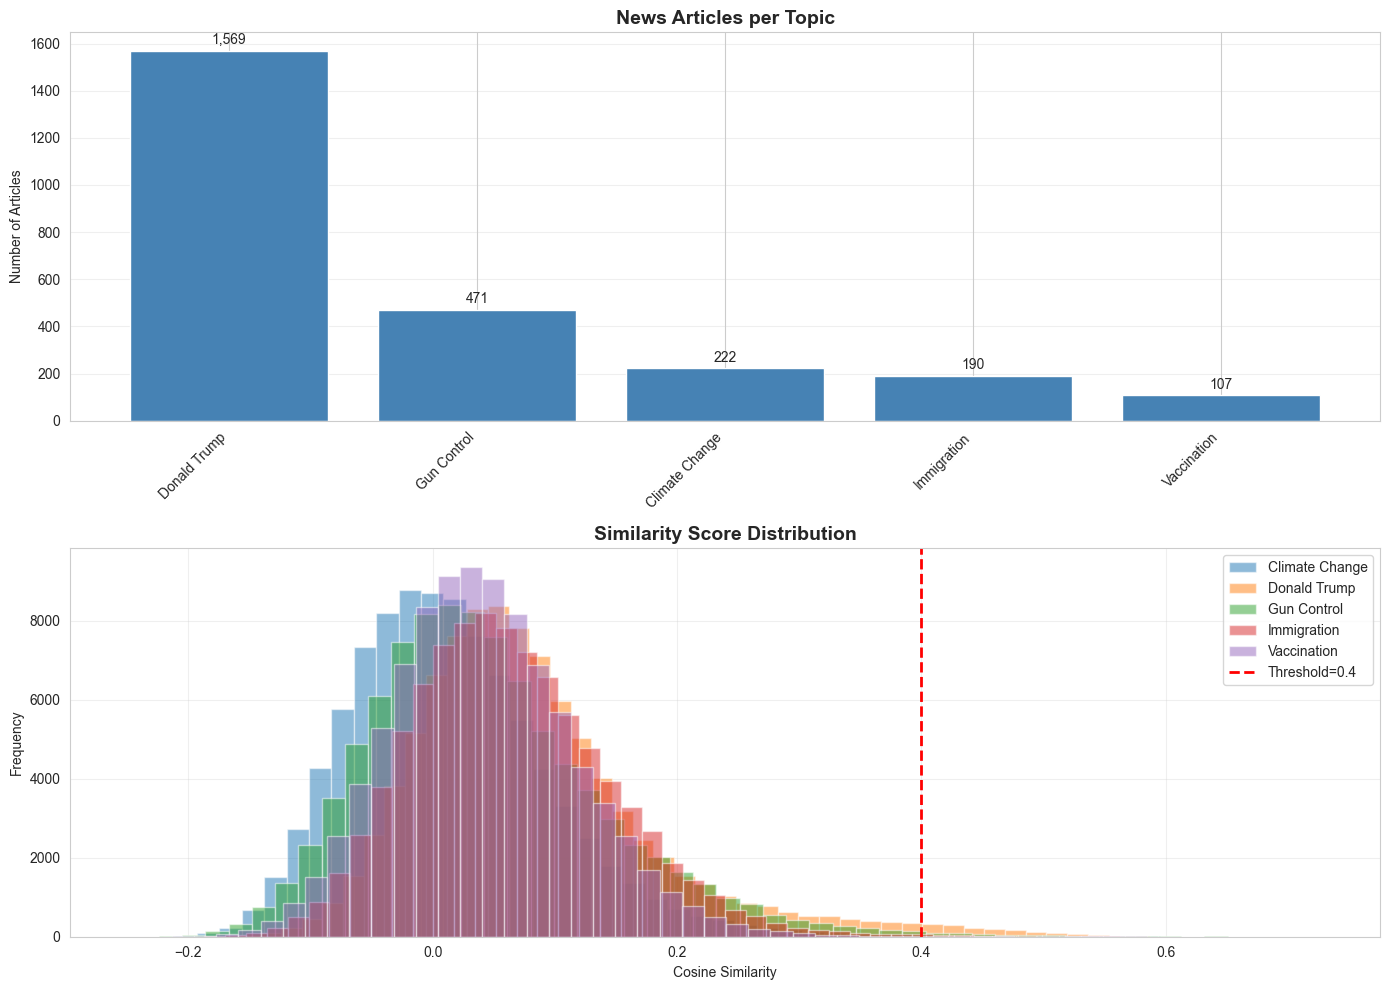

✓ Saved topic distribution visualization


In [18]:

# Plot topic distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Articles per topic
ax = axes[0]
topic_counts_sorted = topic_counts.sort_values(ascending=False)
topic_labels = [topic_definitions[tid]['label'] for tid in topic_counts_sorted.index]
ax.bar(range(len(topic_counts_sorted)), topic_counts_sorted.values, color='steelblue')
ax.set_xticks(range(len(topic_counts_sorted)))
ax.set_xticklabels(topic_labels, rotation=45, ha='right')
ax.set_ylabel('Number of Articles')
ax.set_title('News Articles per Topic', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(topic_counts_sorted.values):
    ax.text(i, v + max(topic_counts_sorted.values)*0.01, f'{v:,}', 
            ha='center', va='bottom', fontsize=10)

# 2. Similarity distribution
ax = axes[1]
for topic_id in topic_ids:
    topic_label = topic_definitions[topic_id]['label']
    sim_col = f'sim_{topic_id}'
    ax.hist(df[sim_col], bins=50, alpha=0.5, label=topic_label)

ax.axvline(x=THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold={THRESHOLD}')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Frequency')
ax.set_title('Similarity Score Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(topics_dir / 'topic_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved topic distribution visualization")

## 8. Temporal Analysis

In [19]:
# Daily topic counts
print("Calculating daily topic distribution...")

df_with_topics = df[df['article_topic'].notna()].copy()

daily_topic_counts = df_with_topics.groupby(['date', 'article_topic']).size().unstack(fill_value=0)
daily_topic_counts = daily_topic_counts.sort_index()

print(f"✓ Calculated daily counts for {len(daily_topic_counts)} days")

Calculating daily topic distribution...
✓ Calculated daily counts for 60 days


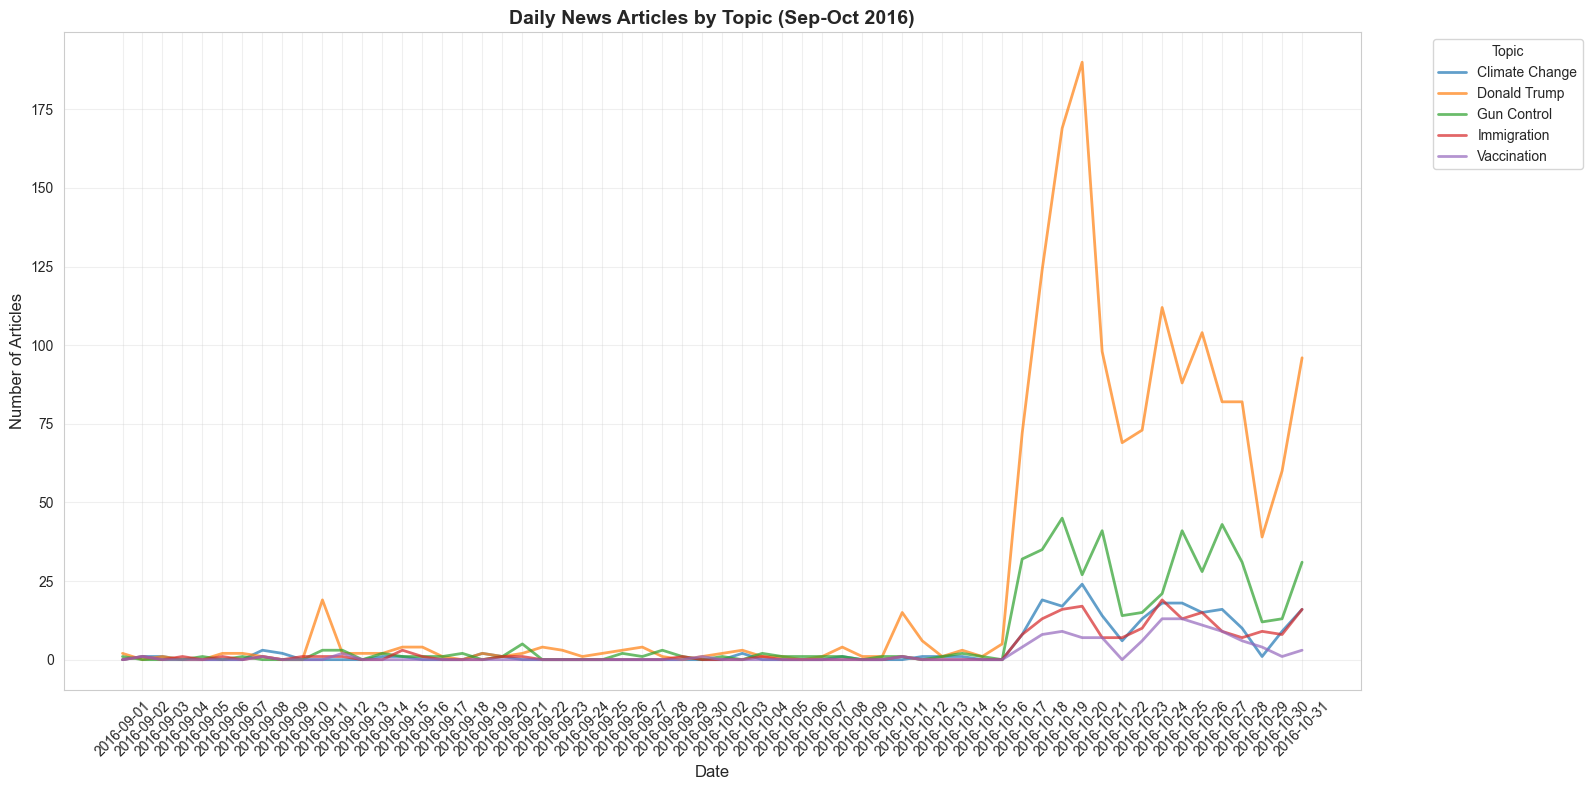

✓ Saved temporal trends visualization


In [20]:
# Plot temporal trends
fig, ax = plt.subplots(figsize=(16, 8))

for topic_id in topic_ids:
    if topic_id in daily_topic_counts.columns:
        topic_label = topic_definitions[topic_id]['label']
        ax.plot(daily_topic_counts.index, daily_topic_counts[topic_id], 
                label=topic_label, linewidth=2, alpha=0.7)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Articles', fontsize=12)
ax.set_title('Daily News Articles by Topic (Sep-Oct 2016)', fontsize=14, fontweight='bold')
ax.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(topics_dir / 'daily_topic_trends.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved temporal trends visualization")

## 9. Sample Articles by Topic

In [21]:
## 9. Sample Articles by Topic

# Show sample articles for each topic
print("Sample articles by topic:\\n")

for topic_id in topic_ids:
    topic_label = topic_definitions[topic_id]['label']
    topic_articles = df[df['article_topic'] == topic_id]
    
    if len(topic_articles) > 0:
        print(f"\n{'='*80}")
        print(f"TOPIC: {topic_label.upper()} ({len(topic_articles):,} articles)")
        print(f"{'='*80}\\n")
        
        # Show 3 samples: 1 high, 1 medium, 1 threshold similarity
        samples = []
        sim_col = f'sim_{topic_id}'
        
        # Highest similarity
        samples.append(topic_articles.nlargest(1, sim_col).iloc[0])
        # Median similarity
        samples.append(topic_articles.iloc[(topic_articles[sim_col] - topic_articles[sim_col].median()).abs().argsort()[:1]].iloc[0])
        # Near threshold
        near_threshold = topic_articles[(topic_articles[sim_col] >= THRESHOLD) & (topic_articles[sim_col] < THRESHOLD + 0.05)]
        if len(near_threshold) > 0:
            samples.append(near_threshold.sample(1, random_state=42).iloc[0])
        
        for i, row in enumerate(samples, 1):
            print(f"Sample {i} (sim={row[sim_col]:.3f}):")
            print(f"  Date: {row['date']}")
            print(f"  Title: {row['title']}")
            print(f"  Text preview: {row['plain_text'][:200]}...")
            print()
    else:
        print(f"\n{topic_label}: No articles found")

Sample articles by topic:\n

TOPIC: CLIMATE CHANGE (222 articles)
================================================================================\n
Sample 1 (sim=0.669):
  Date: 2016-09-20
  Title: The climate has always changed. But then, so has the economy.
  Text preview: Most climate change "skeptics" deny that climate is changing because of our CO2 emissions because they think that to change from a carbon-based economy to a solar based economy would be a total catast...

Sample 2 (sim=0.473):
  Date: 2016-10-31
  Title: Great Barrier Reef: why are government and business perpetuating the big lie?
  Text preview: At the core of the Australian government’s failure to protect our Great Barrier Reef is the big lie.  Through its actions and inaction, rhetoric, funding priorities and policy decisions, the Australia...

Sample 3 (sim=0.433):
  Date: 2016-10-22
  Title: India’s dissent over capping aviation emissions baffles IATA
  Text preview: Global airline body International Air Tran

In [23]:
df_with_topics.head()

,date,requested_url,plain_text,published_date,title,tags,categories,author,sitename,image_url,...,crawl_date,sim_climate_change,sim_donald_trump,sim_gun_control,sim_immigration,sim_vaccination,max_similarity,best_topic_idx,best_topic,article_topic
4,2016-09-01,http://www.bayoubuzz.com/bb/item/1062012-trump...,"Obviously, the major theme on the feeds was Me...",2016-09-01,"Trump, Clinton tweets: Mexico, immigration spe...","Trump, clinton, mexico, immigration, clinton, ...",,Stephen Sabludowsky,bayoubuzz.com,None,...,2016-12-22T23:15:22+00:00,0.048456,0.448504,-0.003913,0.334543,0.041805,0.448504,sim_donald_trump,donald_trump,donald_trump
9,2016-09-01,https://crzyd269.newsvine.com/_news/2016/09/01...,Mayor Rahm Emanuel and Chicago Police Superint...,2016-09-01,Chicago in the midst of most violent month sin...,,,Neither Left or Right; Factual Reality is my P...,Newsvine,None,...,2016-12-27T01:02:09+00:00,0.082440,0.168607,0.471177,0.109729,0.179425,0.471177,sim_gun_control,gun_control,gun_control
19,2016-09-01,http://www.bayoubuzz.com/bb/item/1062013-louis...,United States Senator Bill Cassidy on Thursday...,2016-09-01,"Louisiana US Senator Bill Cassidy says Trump, ...","Louisiana US Senator Bill Cassidy, Donald Trum...",,Stephen Sabludowsky,bayoubuzz.com,None,...,2016-12-22T22:49:57+00:00,0.016293,0.426052,0.073295,0.165363,0.064072,0.426052,sim_donald_trump,donald_trump,donald_trump
138,2016-09-02,http://yournewswire.com/tens-of-thousands-of-s...,"A staggering 30,000 scientists have come forwa...",2016-09-02,Tens of Thousands Of Scientists Declare Climat...,al-gore;climate-change;climate-change-hoax;glo...,News,Sean Adl-Tabatabai,Your News Wire,http://cdns.yournewswire.com/wp-content/upload...,...,2016-12-22T22:44:01+00:00,0.530167,0.211383,-0.001718,0.086993,0.088203,0.530167,sim_climate_change,climate_change,climate_change
158,2016-09-02,http://www.jhsph.edu/news/news-releases/2016/d...,"September 1, 2016 Dengue Vaccine Could Increas...",2016-09-02,Dengue Vaccine Could Increase or Worsen Dengue...,"bloomberg school of public health, school of p...",,Barbara Benham,jhsph.edu,None,...,2016-12-25T02:46:54+00:00,0.081654,0.106441,0.120633,0.090045,0.542742,0.542742,sim_vaccination,vaccination,vaccination


## 10. Save Results

In [24]:
# Save articles with topics
output_file = topics_dir / 'news_articles_with_topics.parquet'

# Select relevant columns (only include those that exist)
base_columns = ['date', 'title', 'plain_text', 'requested_url', 'language', 
                'article_topic', 'max_similarity']
output_columns = [col for col in base_columns if col in df.columns] + sim_cols

print(f"Saving columns: {output_columns}")

# Save only articles with topics (for stance/polarization pipeline)
df_with_topics = df[df['article_topic'].notna()].copy()
write_parquet(df_with_topics[output_columns], output_file)

print(f"✓ Saved: {output_file}")
print(f"  Articles: {len(df_with_topics):,}")
print(f"  Size: {output_file.stat().st_size / 1024 / 1024:.1f} MB")

Saving columns: ['date', 'title', 'plain_text', 'requested_url', 'language', 'article_topic', 'max_similarity', 'sim_climate_change', 'sim_donald_trump', 'sim_gun_control', 'sim_immigration', 'sim_vaccination']
✓ Wrote 2,559 rows to news_articles_with_topics.parquet (4.8 MB)
✓ Saved: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/news/news_articles_with_topics.parquet
  Articles: 2,559
  Size: 4.8 MB


In [25]:
# Save summary statistics
summary = {
    'notebook': '23_news_topic_assignment',
    'timestamp': datetime.now().isoformat(),
    'approach': 'embedding-based (same as Reddit 15b)',
    'model': model_name,
    'threshold': THRESHOLD,
    'data_period': {
        'start_date': df['date'].min(),
        'end_date': df['date'].max()
    },
    'total_articles': int(len(df)),
    'articles_with_topics': int(len(df_with_topics)),
    'articles_without_topics': int(df['article_topic'].isna().sum()),
    'retention_pct': float(len(df_with_topics) / len(df) * 100),
    'topic_distribution': {
        topic_definitions[tid]['label']: int(count) 
        for tid, count in topic_counts.items()
    },
    'methodology': {
        'approach': 'sentence embeddings + cosine similarity',
        'same_as_reddit': True,
        'threshold': THRESHOLD,
        'assignment': 'best topic if similarity >= threshold'
    }
}

summary_file = topics_dir / '23_topic_assignment_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"\n✓ Saved summary: {summary_file}")


✓ Saved summary: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/news/23_topic_assignment_summary.json


## 11. Summary

In [26]:
# Print final summary
print("\n" + "="*80)
print("NEWS TOPIC ASSIGNMENT COMPLETE")
print("="*80)

print(f"\n📊 DATA SUMMARY:")
print(f"  Total articles processed: {len(df):,}")
print(f"  Articles with topics: {len(df_with_topics):,} ({len(df_with_topics)/len(df)*100:.1f}%)")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")

print(f"\n🏷️  TOPIC DISTRIBUTION:")
for topic, count in sorted(topic_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {topic}: {count:,} ({count/len(df)*100:.1f}%)")

print(f"\n🏷️  TOPIC DISTRIBUTION:")
for topic_id, count in sorted(topic_counts.items(), key=lambda x: x[1], reverse=True):
    topic_label = topic_definitions[topic_id]['label']
    print(f"  {topic_label}: {count:,} ({count/len(df_with_topics)*100:.1f}%)")

print(f"\n✅ OUTPUTS CREATED:")
print(f"  • news_articles_with_topics.parquet ({len(df_with_topics):,} articles)")
print(f"  • 23_topic_assignment_summary.json")
print(f"  • topic_distribution.png")
print(f"  • daily_topic_trends.png")

print("\n" + "="*80)
print("METHODOLOGY")
print("="*80)
print(f"\n✓ Same approach as Reddit (notebook 15b)")
print(f"  - Model: {model_name}")
print(f"  - Threshold: {THRESHOLD}")
print(f"  - Assignment: Best topic if similarity >= threshold")
print(f"  - Topics: Same 5 topics from Reddit")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)

print("\n1. APPLY STANCE MODEL:")
print("   - Reuse trained stance model from Reddit (notebook 16b)")
print("   - Apply to news articles with topics")
print("   - Create notebook 24: news_apply_stance_model.ipynb")

print("\n2. CALCULATE POLARIZATION:")
print("   - Use same Esteban-Ray metric as Reddit")
print("   - Calculate daily/weekly polarization")
print("   - Create notebook 25: news_polarization.ipynb")

print("\n3. CROSS-SOURCE COMPARISON:")
print("   - Compare Reddit vs News polarization")
print("   - Analyze differences across platforms")
print("   - Unified analysis notebook")

print("\n" + "="*80)


NEWS TOPIC ASSIGNMENT COMPLETE

📊 DATA SUMMARY:
  Total articles processed: 93,669
  Articles with topics: 2,559 (2.7%)
  Date range: 2016-09-01 to 2016-10-31

🏷️  TOPIC DISTRIBUTION:
  donald_trump: 1,569 (1.7%)
  gun_control: 471 (0.5%)
  climate_change: 222 (0.2%)
  immigration: 190 (0.2%)
  vaccination: 107 (0.1%)

🏷️  TOPIC DISTRIBUTION:
  Donald Trump: 1,569 (61.3%)
  Gun Control: 471 (18.4%)
  Climate Change: 222 (8.7%)
  Immigration: 190 (7.4%)
  Vaccination: 107 (4.2%)

✅ OUTPUTS CREATED:
  • news_articles_with_topics.parquet (2,559 articles)
  • 23_topic_assignment_summary.json
  • topic_distribution.png
  • daily_topic_trends.png

METHODOLOGY

✓ Same approach as Reddit (notebook 15b)
  - Model: sentence-transformers/all-MiniLM-L6-v2
  - Threshold: 0.4
  - Assignment: Best topic if similarity >= threshold
  - Topics: Same 5 topics from Reddit

NEXT STEPS

1. APPLY STANCE MODEL:
   - Reuse trained stance model from Reddit (notebook 16b)
   - Apply to news articles with topics